### Neural Network input/output explorer
This is code allowing to inspect NN input and output durting validation stage. <br>
Call `./train_pose.py save_network_input_output` or `./train_pose.py save_network_input` to get it

In [125]:
%matplotlib inline
import pylab as plt
import struct
import numpy as np
import hashlib
import h5py
import json
import pandas as pd
import cv2
from IPython.display import display, HTML
from ipywidgets import FloatProgress
from time import sleep
import matplotlib
from scipy.ndimage.filters import gaussian_filter, maximum_filter

In [7]:
# configure here

# files = ["nn_io.HeadCount.0006.h5", "nn_io.HeadCount.0011.h5"]   
# files = ["../addins/nn_io.HeadCount.%04d.h5" % i for i in range(35,47) ]
# files = [ "nn_io.HeadCount_ScaleFix.0000.h5" ]
# files = ["../addins/nn_gt.HeadCount_BodyPartsFixed.h5"]
# files = ["../addins/nn_io.HeadCount.0013.h5"]
# files = ["../addins/nn_gt.HeadTrim.h5"]
files = [ "../addins/nn_io.HeadCount_PochtaBrainwashCocohead.0007.h5" ]

# There could be several files, in this case they should be different epochs of same data. 
# i.e. all pictures, ground truth, etc should be same only network output should vary
# equality of ground truth is checked, you could use it for regression tests

In [8]:
# open all h5 files
nnios = [ h5py.File(filename, "r") for filename in files ] 

In [9]:
def get_batch(nnio, key):

    group = nnio[key]

    image = group['x00'].value

    x1 = group['x01'].value
    x2 = group['x02'].value

    mask = np.concatenate((x1,x2), axis=3) 

    gt0 = group['gt00'].value
    gt1 = group['gt01'].value

    if 'y10' in group: 
        Y0 = group['y10'].value
        Y1 = group['y11'].value
    else:
        Y0 = np.zeros(shape=gt0.shape, dtype=np.float)
        Y1 = np.zeros(shape=gt0.shape, dtype=np.float)


    for i in range(6):
        i0 = "%02d" % (i * 2)
        i1 = "%02d" % (i*2+1)

        assert(np.all(group['gt'+i0].value==gt0))
        assert(np.all(group['gt'+i1].value==gt1))

    gt = np.concatenate((gt0,gt1), axis=3) 
    Y = np.concatenate((Y0,Y1), axis=3)

    return image, mask, gt, Y

def iterate_epoch(nnio):

    for key in nnio.keys():
        yield get_batch(nnio,key)


def assert_list_equals(l):
    for i in range(1, len(l)):
        assert np.all(l[0]==l[i])

        
def zip_items(items):        

    images = []
    masks = [] 
    gt = []
    Y = []

    for item in items:
        images.append(item[0])
        masks.append(item[1])
        gt.append(item[2])
        Y.append(item[3])

    assert_list_equals(images)
    assert_list_equals(masks)
    assert_list_equals(gt)

    return images[0], masks[0], gt[0], np.concatenate( [y[...,np.newaxis] for y in Y], axis=4 )

        
def iterate_items(nnios):

    iterators = [iterate_epoch(nnio) for nnio in nnios]
    
    for items in zip(*iterators):
        
        yield zip_items(items)
        
       
        


### Ground Truth exploration
Ground truth available event without trained network, you could get it `./train_pose.py save_network_input` (nb: no **_output** suffix) but complete **input_output** will contain it either

In [15]:
FILE = 0
BATCH = 0
N = 1
LAYER = 56 

# exact layer number will depend on configuration. You always could get it by running congig.py as a program. 
# It will print layer map in this case

#### Show body parts

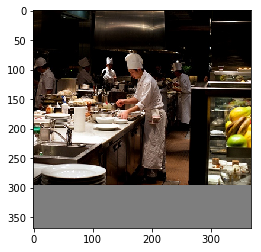

In [16]:
# Lets show picture
images, masks, gt, Ys = get_batch(nnios[FILE], '%06d' % BATCH)
#print(masks[N,:,:])
plt.imshow(images[N,:,:,::-1]+0.5)

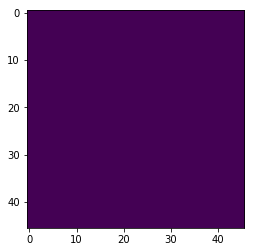

In [17]:
#show gt for LAYER
plt.imshow(gt[N,:,:,LAYER])

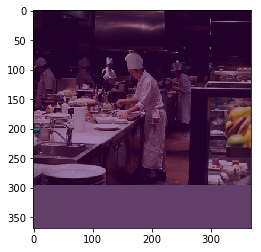

In [18]:
heatmap = cv2.resize(gt[N,:,:,LAYER], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)

plt.imshow(images[N,:,:,::-1]+0.5)
plt.imshow(heatmap[:,:], alpha=.5)

#### Show PAFs
TODO

### This section would work only if you have network output as well, ground truth is not enough

#### Lets look at network output on same images

In [268]:
FILE = 0
BATCH = 316
N = 2
LAYER = 56

images, masks, gt, Ys = get_batch(nnios[FILE], '%06d' % BATCH)

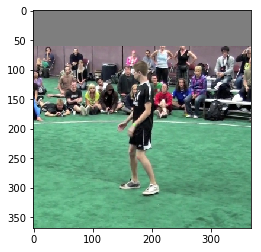

In [269]:
plt.imshow(images[N,:,:,::-1]+0.5)

0.594531


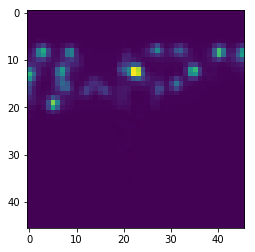

In [270]:
plt.imshow(Ys[N,:,:,LAYER])
print(np.max(Ys[N,:,:,LAYER]))

0.915037139353


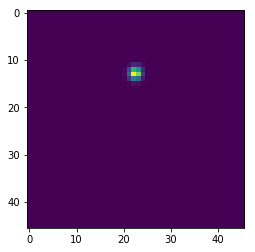

In [271]:
plt.imshow(gt[N,:,:,LAYER])
print(np.max(gt[N,:,:,LAYER]))

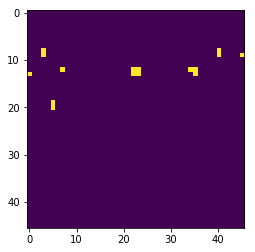

In [272]:
plt.imshow(Ys[N,:,:,LAYER]>0.3)

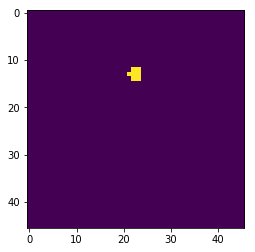

In [273]:
plt.imshow(gt[N,:,:,LAYER]>0.3)

In [274]:
Y = gaussian_filter(cv2.resize(Ys[N,:,:,LAYER], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC), sigma=3.)
GT = gaussian_filter(cv2.resize(gt[N,:,:,LAYER], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC), sigma=3.)
display(np.max(Y), np.max(GT))

0.63245374

0.82789800481775511

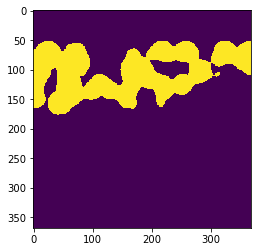

In [275]:
plt.imshow(Y>0.01)

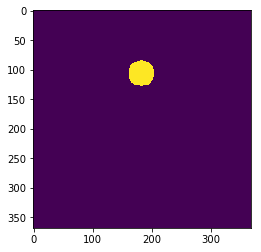

In [276]:
plt.imshow(GT>0.01)

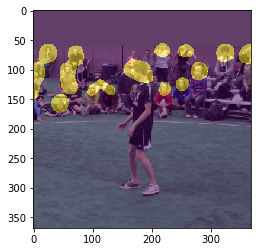

In [277]:
heatmap = cv2.resize(Ys[N,:,:,LAYER], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)

plt.imshow(images[N,:,:,::-1]+0.5)
plt.imshow(Y>0.05, alpha=.5)

#### This iterates all .h5 files and calculates MAE and RMSE metrics for all images, so you could compare it later
nb: nn output L1 and L2 is not MAE and RSME, it is RMSE for PAF(L1) and heatmap(L2) parts of network

In [216]:
# this is find peak function
from scipy.optimize import linear_sum_assignment

def find_peaks(layer, thre1 = 0.01): 

    map_ori = cv2.resize(layer, (0, 0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    map = gaussian_filter(map_ori, sigma=3)
    peaks_binary = (map == maximum_filter(map, 3)) & (map>thre1)
    
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
    peaks_with_score = [x + (map_ori[x[1], x[0]],) for x in peaks]
     
    return peaks_with_score

def assign_peaks(layer_y,layer_gt):

    if len(layer_y)==0 or len(layer_gt)==0:
        return 400*(len(layer_y)+len(layer_gt))
    
    d = np.array(layer_y)
    t = np.array(layer_gt)
 
    dx = np.subtract.outer(d[:,0],t[:,0])
    dy = np.subtract.outer(d[:,1],t[:,1])
    distance = np.sqrt(dx**2 + dy**2)
    #print(distance)

    y, gt = linear_sum_assignment(distance)
    #print(np.array(list(zip(y,gt))))

    dist = [distance[foo] for foo in zip(y,gt)] # TODO: use numpy
    #print(dist)
    dist = np.sum(dist)

    dist += (len(layer_y)-len(y))*400
    dist += (len(layer_gt)-len(gt))*400    
    
    return dist
 
#assign_peaks([(0,0),(10,10)], [(1,1),(4,4),(15,15)])
assign_peaks(find_peaks(Ys[N,:,:,LAYER]), find_peaks(gt[N,:,:,LAYER]))

      
        

416.02899092203086

In [185]:
def calc_metrics(batch_no, gt, Y, heatmap_layers):
    
    MAE = Y-gt[..., np.newaxis]
    MAE = np.abs(MAE)
    MAE = np.mean(MAE, axis=(1,2) )

    RMSE = (Y-gt[..., np.newaxis])**2
    RMSE = np.mean(RMSE, axis=(1,2) )
    RMSE = np.sqrt(RMSE)
    
    # Accuracy01 = (Y > 0.1) == (gt[..., np.newaxis] > 0.1) 
    # Accuracy01 = np.mean(Accuracy01, axis=(1,2) )
    # Accuracy03 = (Y > 0.3) == (gt[..., np.newaxis] > 0.3) 
    # Accuracy03 = np.mean(Accuracy03, axis=(1,2) )
    # Accuracy05 = (Y > 0.5) == (gt[..., np.newaxis] > 0.5) 
    # Accuracy05 = np.mean(Accuracy05, axis=(1,2) )

    gt_parts = np.zeros((gt.shape[0], gt.shape[3]), dtype=np.integer)
    y_parts = np.zeros((gt.shape[0], gt.shape[3]), dtype=np.integer)
    y_dist = np.zeros((gt.shape[0], gt.shape[3]), dtype=np.float)
    
    for n in range(gt.shape[0]):
        for l in heatmap_layers:
            
            y_peaks = find_peaks(Ys[n,:,:,l])
            y_parts[n,l]=len(y_peaks)
            gt_peaks = find_peaks(gt[n,:,:,l])
            gt_parts[n,l]=len(gt_peaks)
            y_dist[n,l] = assign_peaks(y_peaks,gt_peaks)
        


    batch_index = np.full(fill_value=batch_no, shape=MAE.shape)
    item_index, layer_index, epoch_index = np.mgrid[0:MAE.shape[0], 0:MAE.shape[1], 0:MAE.shape[2]]
    
    metrics = pd.DataFrame({ 'batch':batch_index.ravel(), 
                             'item':item_index.ravel(),
                             'layer':layer_index.ravel(),
                             'epoch':epoch_index.ravel(),
                             'MAE':MAE.ravel(),
                             'RMSE':RMSE.ravel(), 
                             'GT_PARTS':gt_parts.ravel(),
                             'Y_PARTS':y_parts.ravel(),
                             'DIST':y_dist.ravel()
                           }, 
                           columns = ('batch','item','layer','epoch', 'MAE', 'RMSE', 'GT_PARTS', 'Y_PARTS', 'DIST')
                          )
    
    return metrics

    
    

In [186]:
HEAT_LAYERS = (56,)

batch_num = 0
max_batches = len(nnios[0].keys())
metrics = []

progress = FloatProgress(min=0, max=max_batches)
display(progress)

for image, mask, gt, Ys in iterate_items(nnios):
   
    metrics.append(calc_metrics(batch_num, gt, Ys, HEAT_LAYERS))
    batch_num += 1
    progress.value = batch_num
    sleep(.01)
    
metrics = pd.concat(metrics)

#could be very long operation - save for later
metrics.to_csv("metrics.tsv", sep="\t")


## Deep metric analytic

In [257]:
#### Lets look into newly acquired metrics
display(metrics[(metrics.layer==LAYER) & (metrics.batch==316)])

,batch,item,layer,epoch,MAE,RMSE,GT_PARTS,Y_PARTS,DIST
56,316,0,56,0,0.001322,0.008519,1,3,802.000000
114,316,1,56,0,0.003483,0.020230,1,5,1603.162278
172,316,2,56,0,0.012980,0.044911,1,18,6802.236068
230,316,3,56,0,0.009430,0.036657,1,17,6401.000000
288,316,4,56,0,0.014552,0.051618,1,20,7601.000000
346,316,5,56,0,0.013374,0.051597,1,19,7201.414214
404,316,6,56,0,0.014042,0.052665,1,22,8402.000000
462,316,7,56,0,0.016688,0.057540,1,21,8002.000000
520,316,8,56,0,0.003270,0.022329,1,4,1202.000000
578,316,9,56,0,0.004815,0.038948,1,5,1605.830952


In [ ]:
#we have several types of collections 

In [220]:
metrics[["layer","epoch","MAE","RMSE","DIST"]].groupby(["layer","epoch"]).mean()

,,MAE,RMSE,DIST
layer,epoch,,,
0,0,0.001838,0.007066,0.000000
1,0,0.003639,0.019538,0.000000
2,0,0.001080,0.007216,0.000000
3,0,0.002042,0.013809,0.000000
4,0,0.000671,0.004845,0.000000
5,0,0.001719,0.011703,0.000000
6,0,0.001210,0.006928,0.000000
7,0,0.003576,0.019544,0.000000
8,0,0.001138,0.007110,0.000000


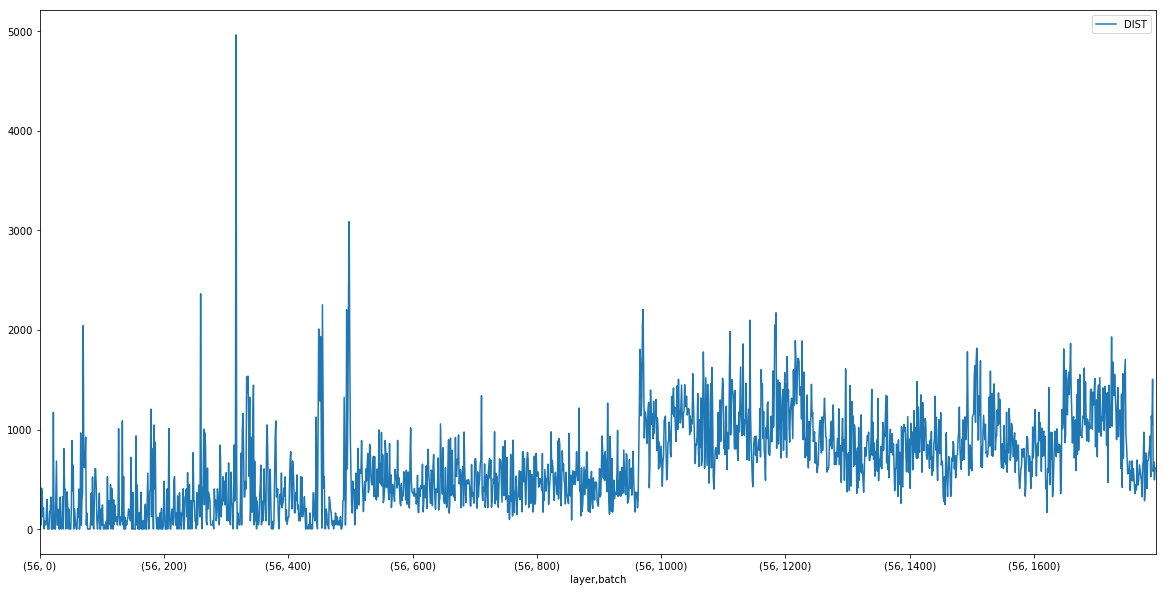

In [239]:
last_epoch = metrics[(metrics.epoch==np.max(metrics.epoch)) & (metrics.layer==56)]
last_epoch = last_epoch[["batch", "layer","DIST"]].groupby(["layer","batch"]).mean()

fig, ax = plt.subplots(figsize=(20, 10))
for key, grp in last_epoch.groupby(['layer']):
    ax = grp.plot(ax=ax, kind='line', label='')


/opt/anaconda3/envs/gpu_tf_intel/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


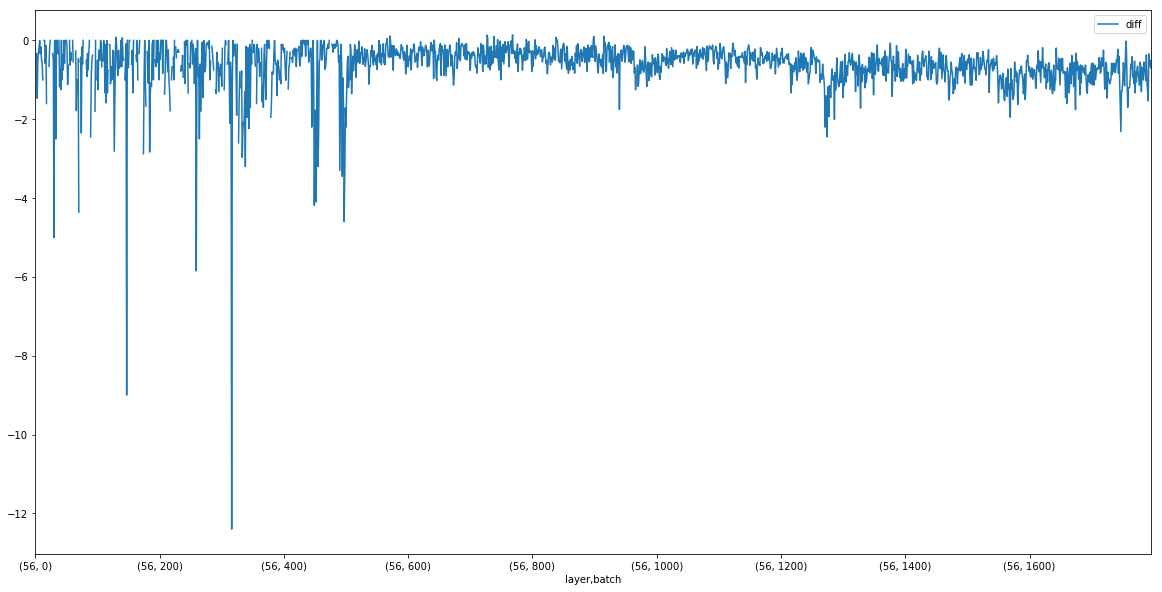

In [241]:
last_epoch = metrics[(metrics.epoch==np.max(metrics.epoch)) & (metrics.layer==56)]
last_epoch['diff']=(last_epoch['GT_PARTS']-last_epoch['Y_PARTS'])*1.0/last_epoch['GT_PARTS']

last_epoch = last_epoch[["batch", "layer","diff"]].groupby(["layer","batch"]).mean()

fig, ax = plt.subplots(figsize=(20, 10))
for key, grp in last_epoch.groupby(['layer']):
    ax = grp.plot(ax=ax, kind='line', label='')

In [255]:
last_epoch[last_epoch['diff']==np.min(last_epoch['diff'][np.isfinite(last_epoch['diff'])])]

,,diff
layer,batch,
56,316,-12.4


In [279]:
display(last_epoch)

Empty DataFrame
Columns: []
Index: [(56, 0), (56, 1), (56, 2), (56, 3), (56, 4), (56, 5), (56, 6), (56, 7), (56, 8), (56, 9), (56, 10), (56, 11), (56, 12), (56, 13), (56, 14), (56, 15), (56, 16), (56, 17), (56, 18), (56, 19), (56, 20), (56, 21), (56, 22), (56, 23), (56, 24), (56, 25), (56, 26), (56, 27), (56, 28), (56, 29), (56, 30), (56, 31), (56, 32), (56, 33), (56, 34), (56, 35), (56, 36), (56, 37), (56, 38), (56, 39), (56, 40), (56, 41), (56, 42), (56, 43), (56, 44), (56, 45), (56, 46), (56, 47), (56, 48), (56, 49), (56, 50), (56, 51), (56, 52), (56, 53), (56, 54), (56, 55), (56, 56), (56, 57), (56, 58), (56, 59), (56, 60), (56, 61), (56, 62), (56, 63), (56, 64), (56, 65), (56, 66), (56, 67), (56, 68), (56, 69), (56, 70), (56, 71), (56, 72), (56, 73), (56, 74), (56, 75), (56, 76), (56, 77), (56, 78), (56, 79), (56, 80), (56, 81), (56, 82), (56, 83), (56, 84), (56, 85), (56, 86), (56, 87), (56, 88), (56, 89), (56, 90), (56, 91), (56, 92), (56, 93), (56, 94), (56, 95), (56, 96), (56, 97), (56, 98), (56, 99), ...]

[1797 rows x 0 columns]

### just trash from here
TODO

In [ ]:
HeadCenter = 56 # if you looking at public project there is no such layer in config

metricsHeadCenter = metrics[(metrics.layer==HeadCenter) & (metrics.L1!=0.)]
display(metricsHeadCenter)

In [ ]:
#calculate average metrics

metricsHeadCenterByEpoch = metricsHeadCenter.groupby(["epoch"]).mean()
display(metricsHeadCenterByEpoch)

In [ ]:
display(metricsHeadCenter[metricsHeadCenter.L2==np.max(metricsHeadCenter.L2)])

In [ ]:
images, masks, gt, Ys = get_batch(nnios[0], '000403')
N = 0 

In [ ]:
plt.imshow(images[1,:,:,::-1]+0.5)

In [ ]:
plt.imshow(gt[1,:,:,56])

In [ ]:
plt.imshow(Ys[1,:,:,56])

In [ ]:
epoch0 = metrics[metrics.epoch==0]
epoch1 = metrics[metrics.epoch==11]

merged = epoch0.merge(epoch1, on=('batch', 'item', 'layer') )
merged['L1_diff']=merged['L1_y']-merged['L1_x']
merged['L2_diff']=merged['L2_y']-merged['L2_x']
display(merged)


In [ ]:
merged[merged.L1_diff==np.max(merged.L1_diff)]

In [ ]:
images, masks, gt, Y0 = get_batch(nnios[0], '000404')
images, masks, gt, Y1 = get_batch(nnios[11], '000404')
N = 0 
L = HeadCenter
plt.imshow(images[0,:,:,::-1]+0.5)

In [ ]:
plt.imshow(gt[N,:,:,L])

In [ ]:
display(pd.DataFrame(gt[N,:,:,L]))

In [ ]:
plt.imshow((Y0[N,:,:,L]*128+128).astype(np.uint8))

In [ ]:
(Y1[N,:,:,L]*128+128).astype(np.uint8)

In [ ]:
plt.imshow((Y1[N,:,:,L]*128+128).astype(np.uint8))

In [ ]:
Y1[N,:,:,L]

In [ ]:
for i in range(247):    
    old_group = old['%06d' % i]
    new_group = new['%06d' % i]

    Ynames = [] # ['y%02d'%d for d in range(12)]
    GTnames = ['gt%02d'%d for d in range(12)]
    
    for name in ['x00','x01','x02']+Ynames+GTnames:
        item_old = old_group[name].value
        item_new = new_group[name].value
    
        if np.any(item_old!=item_new):
            print(i, name, item_old.shape, item_new.shape)



In [ ]:
results = []

for i in range(247):    
    old_group = old['%06d' % i]
    new_group = new['%06d' % i]

    gt_old =   old_group['gt11'].value
    item_old = old_group['y11'].value

    gt_new =   new_group['gt11'].value
    item_new = new_group['y11'].value

    assert np.all(gt_old==gt_new)
    
    for j in range(10):
    
        mae_old =  np.mean(np.abs(gt_old[j]-item_old[j]))
        mae_new =  np.mean(np.abs(gt_new[j]-item_new[j]))    
        mae_diff = abs(mae_old-mae_new)
    
        results += [ [i, j, mae_old, mae_new, mae_diff] ]

results = np.array(results)

In [ ]:
pd.DataFrame(results[results[:,4]==np.max(results[:,4])])

In [ ]:
img_old = (old['000190']['x00'][7]).astype(np.uint8)
#p_old = ((old['000000']['x00'][1]+0.5)*256).astype(np.uint8)
img_old = img_old [...,::-1]
print(img_old.shape)
plt.imshow(img_old)

In [ ]:
img_new = (new['000190']['x00'][7]+0.5)
img_new = img_new [...,::-1]
print(img_new.shape)
plt.imshow(img_new)

In [ ]:
p_diff = img_new*256-img_old
p_diff = (p_diff+127).astype(np.uint8)
#print(p_diff)
plt.imshow(p_diff)

In [ ]:
p_new = new['000190']['y11'][7]
p_new = p_new[:,:,5]
print(p_new.shape)
p_new = cv2.resize(p_new, (0,0), fx=8, fy=8)
plt.imshow(img_new)
plt.imshow(p_new, alpha=.5)



In [ ]:
p_old = old['000190']['y11'][7]
p_old = p_old[:,:,5]
print(p_old.shape)
p_old = cv2.resize(p_old, (0,0), fx=8, fy=8)
plt.imshow(img_old)
plt.imshow(p_old, alpha=.5)

In [ ]:
p_new = new['000000']['x01']
p_new = (p_new[1,:,:,0]*255).astype(np.uint8)
print(p_new.shape)
print(p_new)
plt.imshow(p_new)

In [ ]:
p_old = old['000000']['x01']
p_old = (p_old[1,:,:,4]*255).astype(np.uint8)
print(p_old.shape)
print(p_old)
plt.imshow(p_old)

In [ ]:
p_new = new['000000']['x01'].value
p_old = old['000000']['x01'].value
p_diff = p_new - p_old

In [ ]:
image = cv2.imread("../sample_images/ski.jpg")
plt.imshow(image)